In [1]:
# Import Libraries
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from IPython.display import Image

In [2]:
#Read Database from the Wikipedia page

d = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

df = d[0]

df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Drop entries where Borough is Not assigned

In [3]:
df = df[df['Borough'] != 'Not assigned']

In [4]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Check for 'Not assigned' neighborhoods to replace

In [5]:
# Are there any Neighborhoods not asigned?

print(df[df['Neighborhood'] == "Not assigned"]['Neighborhood'].count())

print('All Neighborhoods are asigned')

0
All Neighborhoods are asigned


## Combine neighborhods belonging to the same Postal Code in one entry.

In [6]:
# First let's check for repeated Postal Codes
df['Postal Code'].value_counts()

M2P    1
M4L    1
M6H    1
M1H    1
M9P    1
      ..
M7R    1
M7A    1
M1E    1
M1C    1
M4V    1
Name: Postal Code, Length: 103, dtype: int64

## All Postal codes are already in the correct format in the Wikipedia page

# Shape of Data Frame

In [7]:
df.shape

(103, 3)

# Read CSV with geographical coordinates

In [8]:
coord_df = pd.read_csv('Geospatial_Coordinates.csv')


In [9]:
coord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Merge the Neighborhood Data Frame with the Coordinate Data Frame

In [10]:
df = pd.merge(df, coord_df, on ='Postal Code')

In [11]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [12]:
df.groupby('Borough').count()

,Postal Code,Neighborhood,Latitude,Longitude
Borough,,,,
Central Toronto,9,9,9,9
Downtown Toronto,19,19,19,19
East Toronto,5,5,5,5
East York,5,5,5,5
Etobicoke,12,12,12,12
Mississauga,1,1,1,1
North York,24,24,24,24
Scarborough,17,17,17,17
West Toronto,6,6,6,6


## We will use the neighborhoods in Boroughs with Toronto in the name

In [13]:
df_toronto = df[df['Borough'].str.contains('Toronto', regex = True)].reset_index(drop = True)

In [14]:
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


## Get map of Toronto

In [15]:
# Define Latitude and Longitude of Toronto
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates are {}, {}'.format(latitude, longitude))

The coordinates are 43.6534817, -79.3839347


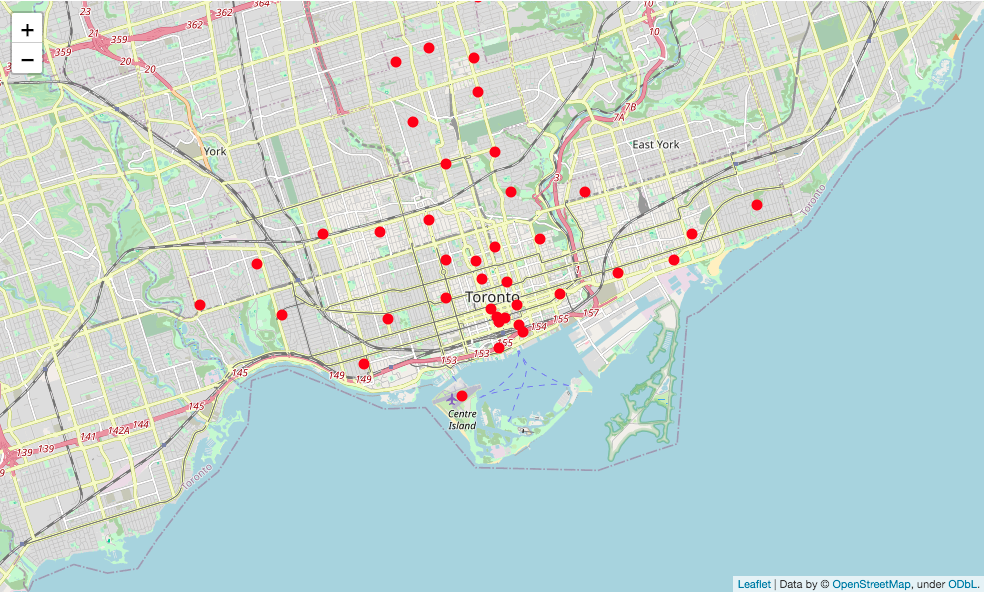

In [16]:
# Make Map of Toronto with Neighborhoods

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add the Neighborhoods as green circle markers
for lat, lng, borough, neighborhood in zip(df_toronto.Latitude, 
                                           df_toronto.Longitude, 
                                           df_toronto.Neighborhood,
                                          df_toronto.Borough):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=1
    ).add_to(map_toronto)

# display map
map_toronto

# Since Folium maps do not display in Github, I have attached an immage of the map

Image(filename='map_toronto.png') 

## Foursquare credentials

In [17]:
CLIENT_ID = 'UPFUJX2YZLG4F5IMCQY5IUTUKY12FCD0YFDWKE40TFS2QPQW' # your Foursquare ID
CLIENT_SECRET = 'ZWK0P1HNFOHB3W5JV4YGN45IFXI2VWADI05MSFSEX3EUCZU2' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UPFUJX2YZLG4F5IMCQY5IUTUKY12FCD0YFDWKE40TFS2QPQW
CLIENT_SECRET:ZWK0P1HNFOHB3W5JV4YGN45IFXI2VWADI05MSFSEX3EUCZU2


### Now, let's get the top 50 venues that are in each borough within a radius of 500 meters.

In [18]:
LIMIT = 50

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
      
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# Call function for the Toronto Database

toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

In [20]:
print(toronto_venues.shape)
toronto_venues.head(10)

(1195, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
6,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
7,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
8,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,"Regent Park, Harbourfront",43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot


## Let's see how many venues were returned for each Toronto neighborhood

In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,50,50,50,50,50,50
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
Business reply mail Processing Centre,18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,50,50,50,50,50,50
Christie,17,17,17,17,17,17
Church and Wellesley,50,50,50,50,50,50
"Commerce Court, Victoria Hotel",50,50,50,50,50,50
Davisville,35,35,35,35,35,35


In [22]:
print( 'There are {} unique venue categories.'.format(toronto_venues['Venue Category'].nunique()))

There are 218 unique venue categories.


## Let's analize each neighborhood

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
toronto_onehot = toronto_onehot[['Neighborhood'] +  
                                [col for col in toronto_onehot.columns if col != 'Neighborhood']]

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.00000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.043478
2,Business reply mail Processing Centre,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.055556
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.058824,0.058824,0.058824,0.117647,0.176471,0.058824,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.00000,0.020000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.02,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.040000
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.02000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.028571,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000


## Let's put the top 10 most common venues for each neighborhood into a Dataframe

In [25]:
num_top_venues = 10
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Restaurant,Bakery,Café,Cheese Shop,Seafood Restaurant,Farmers Market,Fish Market
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Burrito Place,Nightclub,Restaurant,Italian Restaurant,Intersection,Bar,Stadium
2,Business reply mail Processing Centre,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Burrito Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport,Harbor / Marina,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Bubble Tea Shop,Ice Cream Shop,Falafel Restaurant,Hotel,Indian Restaurant


# Cluster the neighborhoods


In [26]:
#Run k-means to cluster the neighborhood into 3 clusters.

# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


In [27]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Park,Bakery,Restaurant,Breakfast Spot,Café,Theater,Shoe Store,Spa
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Creperie,Beer Bar,Sandwich Place,Restaurant,Burrito Place,Café,Park,College Auditorium
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Café,Theater,Restaurant,Bookstore,Ramen Restaurant,Tea Room,Cosmetics Shop,Clothing Store,Middle Eastern Restaurant,Coffee Shop
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Gastropub,American Restaurant,Seafood Restaurant,Creperie,Cosmetics Shop,Italian Restaurant,Restaurant,Diner
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Health Food Store,Pub,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


## Let's visualize the clusters

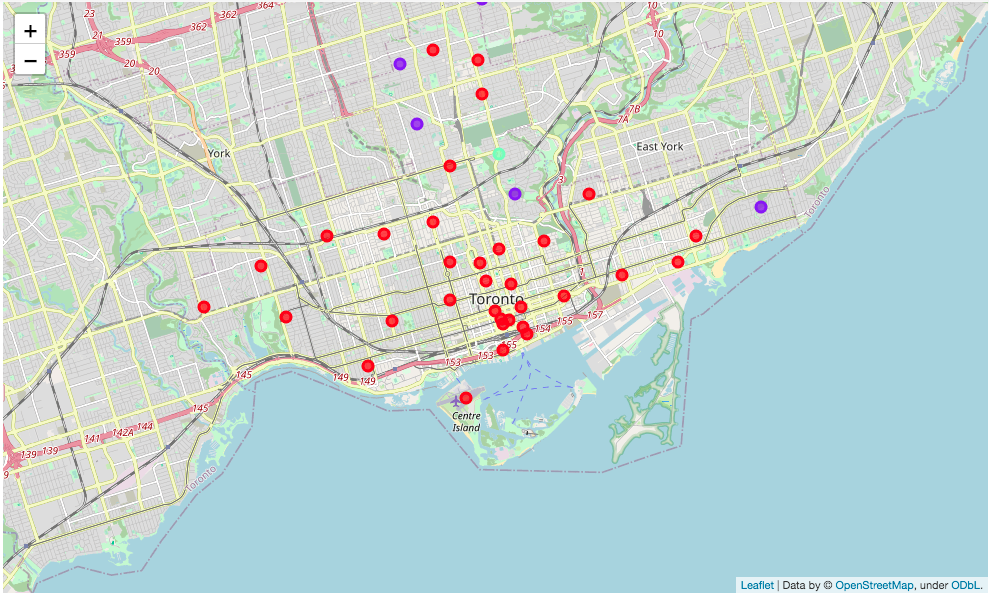

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# Display Map
map_clusters

# Since Folium maps do not display in Github, I have attached an immage of the map

Image(filename='map_toronto_cluster.png')

## Let's see how many neighborhoods per cluster

In [29]:
toronto_merged['Cluster Labels'].value_counts()

0    33
1     5
2     1
Name: Cluster Labels, dtype: int64

### Let's look at the unique neighborhood in cluster #2

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,2,Playground,Tennis Court,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
